In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# --- 1. Load the Datasets ---
try:
    flight_df = pd.read_csv("Flight Level Data.csv")
    bag_df = pd.read_csv("Bag+Level+Data.csv")
    pnr_flight_df = pd.read_csv("PNR+Flight+Level+Data.csv")
    pnr_remark_df = pd.read_csv("PNR Remark Level Data.csv")
except FileNotFoundError as e:
    print(f"Error: One of the files was not found. Please ensure all files are uploaded. {e}")
    exit()

# --- Initial Datetime Conversion and Delay Calculation ---
flight_df['scheduled_departure_datetime_local'] = pd.to_datetime(flight_df['scheduled_departure_datetime_local'], utc=True)
flight_df['actual_departure_datetime_local'] = pd.to_datetime(flight_df['actual_departure_datetime_local'], utc=True)
flight_df['departure_delay_minutes'] = (
    flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

def create_flight_key(df):
    return df['company_id'].astype(str) + '_' + \
           df['flight_number'].astype(str) + '_' + \
           df['scheduled_departure_date_local'].astype(str) + '_' + \
           df['scheduled_departure_station_code'].astype(str) + '_' + \
           df['scheduled_arrival_station_code'].astype(str)

# Add flight keys
flight_df['flight_key'] = create_flight_key(flight_df)
pnr_flight_df['flight_key'] = create_flight_key(pnr_flight_df)


In [ ]:
# ====================================================================
# Q2. Flight Difficulty Score Development (Feature Engineering)
# ====================================================================

# --- A. Features from Flight Level Data (Ground Constraints, Delay) ---
flight_features = flight_df[[
    'flight_key', 'company_id', 'flight_number', 'scheduled_departure_date_local',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code',
    'minimum_turn_minutes', 'scheduled_ground_time_minutes',
    'total_seats', 'departure_delay_minutes'
]].copy()
flight_features['ground_time_buffer_minutes'] = flight_features['scheduled_ground_time_minutes'] - flight_features['minimum_turn_minutes']


# --- B. Features from PNR Flight Level Data (Load/Passenger Needs) ---
pnr_pax_grouped = pnr_flight_df.groupby(['flight_key', 'record_locator'])['total_pax'].max().reset_index()
total_pax_per_flight = pnr_pax_grouped.groupby('flight_key')['total_pax'].sum().reset_index(name='total_passengers')

pnr_child = pnr_flight_df[(pnr_flight_df['is_child'] == 'Y') | (pnr_flight_df['lap_child_count'] > 0)].copy()
pnr_child['child_pax_count'] = 1
child_pax_grouped = pnr_child.groupby(['flight_key', 'record_locator'])['child_pax_count'].max().reset_index()
total_child_pax_per_flight = child_pax_grouped.groupby('flight_key')['child_pax_count'].sum().reset_index(name='total_child_pax')


# --- C. Features from PNR Remark Level Data (Special Service Requests) ---
ssr_count_per_pnr = pnr_remark_df.groupby('record_locator')['special_service_request'].count().reset_index(name='ssr_count_pnr')
pnr_flight_ssr_merged = pnr_flight_df[['flight_key', 'record_locator']].merge(ssr_count_per_pnr, on='record_locator', how='left')
pnr_flight_ssr_merged['ssr_count_pnr'] = pnr_flight_ssr_merged['ssr_count_pnr'].fillna(0)
total_ssr_per_flight = pnr_flight_ssr_merged.groupby('flight_key')['ssr_count_pnr'].sum().reset_index(name='total_ssr_count')


# --- D. Features from Bag Level Data (Baggage Complexity) ---
# Create key mapping to merge bag data
key_mapping = flight_df[['flight_key', 'company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code']].drop_duplicates()
key_mapping['flight_key_short'] = key_mapping['company_id'].astype(str) + '_' + key_mapping['flight_number'].astype(str) + '_' + key_mapping['scheduled_departure_date_local'].astype(str) + '_' + key_mapping['scheduled_departure_station_code'].astype(str)
key_mapping = key_mapping[['flight_key_short', 'flight_key']].drop_duplicates()

bag_df['flight_key_short'] = bag_df['company_id'].astype(str) + '_' + bag_df['flight_number'].astype(str) + '_' + bag_df['scheduled_departure_date_local'].astype(str) + '_' + bag_df['scheduled_departure_station_code'].astype(str)
bag_df = bag_df.merge(key_mapping, on='flight_key_short', how='left')
transfer_bags = bag_df[bag_df['bag_type'] == 'Transfer'].groupby('flight_key')['bag_tag_unique_number'].count().reset_index(name='total_transfer_bags')


# --- E. Master Merge, Imputation, and Load Factor Calculation ---
master_df = flight_features.merge(total_pax_per_flight, on='flight_key', how='left')
master_df = master_df.merge(total_child_pax_per_flight, on='flight_key', how='left')
master_df = master_df.merge(total_ssr_per_flight, on='flight_key', how='left')
master_df = master_df.merge(transfer_bags, on='flight_key', how='left')

# Imputation (0 for missing PNR/Bag counts)
master_df[['total_passengers', 'total_child_pax', 'total_ssr_count', 'total_transfer_bags']] = \
    master_df[['total_passengers', 'total_child_pax', 'total_ssr_count', 'total_transfer_bags']].fillna(0)

# Load Factor
master_df['load_factor'] = master_df['total_passengers'] / master_df['total_seats']
master_df.loc[master_df['total_seats'] == 0, 'load_factor'] = np.nan
master_df['load_factor'] = master_df['load_factor'].fillna(0)

feature_cols = ['ground_time_buffer_minutes', 'total_transfer_bags', 'total_ssr_count', 'load_factor', 'total_child_pax']
for col in feature_cols:
    master_df[col].fillna(master_df[col].median(), inplace=True)


# --- F. Standardization and Weighted Score Calculation ---
weights = {
    'ground_time_buffer_minutes': 0.40,
    'total_ssr_count': 0.25,
    'total_transfer_bags': 0.15,
    'load_factor': 0.10,
    'total_child_pax': 0.10
}

standardized_df = pd.DataFrame()
for col in feature_cols:
    mean = master_df[col].mean()
    std = master_df[col].std()
    standardized_df[f'z_{col}'] = (master_df[col] - mean) / std

master_df['difficulty_score'] = 0
master_df['difficulty_score'] += standardized_df['z_total_transfer_bags'] * weights['total_transfer_bags']
master_df['difficulty_score'] += standardized_df['z_total_ssr_count'] * weights['total_ssr_count']
master_df['difficulty_score'] += standardized_df['z_load_factor'] * weights['load_factor']
master_df['difficulty_score'] += standardized_df['z_total_child_pax'] * weights['total_child_pax']
master_df['difficulty_score'] += standardized_df['z_ground_time_buffer_minutes'] * weights['ground_time_buffer_minutes'] * -1

# --- G. Daily Ranking and Classification ---
master_df['daily_difficulty_rank'] = master_df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(
    method='min', ascending=False
)
master_df['difficulty_class'] = master_df.groupby('scheduled_departure_date_local')['difficulty_score'].transform(
    lambda x: pd.qcut(x, q=3, labels=['Easy', 'Medium', 'Difficult'], duplicates='drop')
)
master_df['difficulty_class'] = master_df['difficulty_class'].astype(str).replace('nan', 'Medium')

/tmp/ipython-input-3493007123.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(master_df[col].median(), inplace=True)


In [ ]:
# ====================================================================
# Q3. Post-Analysis & Operational Insights
# ====================================================================

print("\n" + "="*80)
print("             FLIGHT DIFFICULTY SCORING AND OPERATIONAL INSIGHTS")
print("="*80)
print(f"Total flights scored: {len(master_df)}")
print("\nFeatures used (Weights):")
for k, v in weights.items():
    print(f"  - {k:<30}: {v*100:.0f}%")
print("-" * 80)

# --- 1. Top 10 Destinations Summary ---
destination_summary = master_df.groupby('scheduled_arrival_station_code').agg(
    avg_difficulty_score=('difficulty_score', 'mean'),
    avg_departure_delay_minutes=('departure_delay_minutes', 'mean'),
    total_flights=('flight_key', 'count')
).sort_values(by='avg_difficulty_score', ascending=False).head(10).reset_index()

print("\n(A) Top 10 Destinations by Average Difficulty Score:")
print("Note: Difficulty score reflects inherent complexity. Avg delay is the actual outcome.")
print(destination_summary[['scheduled_arrival_station_code', 'avg_difficulty_score', 'avg_departure_delay_minutes', 'total_flights']].to_markdown(index=False, floatfmt=".2f"))
print("-" * 80)



             FLIGHT DIFFICULTY SCORING AND OPERATIONAL INSIGHTS
Total flights scored: 8099

Features used (Weights):
  - ground_time_buffer_minutes    : 40%
  - total_ssr_count               : 25%
  - total_transfer_bags           : 15%
  - load_factor                   : 10%
  - total_child_pax               : 10%
--------------------------------------------------------------------------------

(A) Top 10 Destinations by Average Difficulty Score:
Note: Difficulty score reflects inherent complexity. Avg delay is the actual outcome.
| scheduled_arrival_station_code   |   avg_difficulty_score |   avg_departure_delay_minutes |   total_flights |
|:---------------------------------|-----------------------:|------------------------------:|----------------:|
| GRU                              |                   2.23 |                         67.93 |              15 |
| BRU                              |                   2.17 |                         42.67 |              15 |
| ATH        

In [ ]:
# --- 2. Common Drivers Analysis (Correlation Table) ---
corr_df_clean = master_df.dropna(subset=['departure_delay_minutes'] + feature_cols)
feature_delay_corr = corr_df_clean[['departure_delay_minutes'] + feature_cols].corr()['departure_delay_minutes'].sort_values(ascending=False).to_dict()

# Prepare correlation table
corr_data = []
for k, v in feature_delay_corr.items():
    if k != 'departure_delay_minutes':
        corr_data.append([k, f"{v:.4f}"])

corr_df = pd.DataFrame(corr_data, columns=['Feature', 'Correlation with Actual Delay'])

print("\n(B) Common Drivers Analysis (Correlation of Features with Actual Delay):")
print("This shows the actual predictive power of the features against realized delay:")
print(corr_df.to_markdown(index=False))
print("-" * 80)



(B) Common Drivers Analysis (Correlation of Features with Actual Delay):
This shows the actual predictive power of the features against realized delay:
| Feature                    |   Correlation with Actual Delay |
|:---------------------------|--------------------------------:|
| total_transfer_bags        |                          0.0702 |
| total_ssr_count            |                          0.0407 |
| total_child_pax            |                         -0.0156 |
| ground_time_buffer_minutes |                         -0.0306 |
| load_factor                |                         -0.1763 |
--------------------------------------------------------------------------------


In [ ]:
# --- 3. Detailed Drivers for Top 10 Difficult Destinations ---
top_10_destinations = destination_summary['scheduled_arrival_station_code'].unique()
filtered_df = master_df[master_df['scheduled_arrival_station_code'].isin(top_10_destinations)]

driver_analysis = filtered_df.groupby('scheduled_arrival_station_code')[feature_cols + ['departure_delay_minutes']].mean().reset_index()

# Merge back the avg_difficulty_score for accurate sorting
driver_analysis = driver_analysis.merge(
    destination_summary[['scheduled_arrival_station_code', 'avg_difficulty_score']],
    on='scheduled_arrival_station_code',
    how='left'
).sort_values(by='avg_difficulty_score', ascending=False)
driver_analysis = driver_analysis.drop(columns='avg_difficulty_score')
driver_analysis = driver_analysis.set_index('scheduled_arrival_station_code')

print("\n(C) Detailed Drivers for Top 10 Difficult Destinations (Average Feature Values):")
print(driver_analysis.to_markdown(floatfmt=".2f"))
print("-" * 80)




(C) Detailed Drivers for Top 10 Difficult Destinations (Average Feature Values):
| scheduled_arrival_station_code   |   ground_time_buffer_minutes |   total_transfer_bags |   total_ssr_count |   load_factor |   total_child_pax |   departure_delay_minutes |
|:---------------------------------|-----------------------------:|----------------------:|------------------:|--------------:|------------------:|--------------------------:|
| GRU                              |                       203.67 |                226.27 |             46.80 |          0.89 |             13.53 |                     67.93 |
| BRU                              |                       460.80 |                248.53 |             43.20 |          0.94 |             17.87 |                     42.67 |
| ATH                              |                        71.00 |                147.40 |             32.00 |          0.93 |             12.33 |                     15.53 |
| HNL                              |  

In [ ]:
# --- 4. Operational Recommendations Table ---
recommendations_data = {
    "Area of Focus": ["Tight Ground Time", "Transfer Baggage", "Special Service Requests", "Scheduling"],
    "Recommendation": [
        "Implement Priority Turn Teams and special procedures for low-buffer turns.",
        "Automate or dedicate resources to the transfer bag process to prevent misconnects and delays.",
        "Pre-assign dedicated teams (e.g., wheelchair assistance) using the score for proactive staging.",
        "Introduce a longer, more realistic scheduled ground time buffer for consistently difficult international routes."
    ],
    "Action Based on Score": [
        "Focus on flights with low/negative 'ground_time_buffer_minutes' and a 'Difficult' class rank.",
        "Focus on flights to GRU, BRU, HND (highest 'total_transfer_bags').",
        "Focus on all flights ranked 'Difficult', prioritizing those with high 'total_ssr_count'.",
        "Focus on GRU, BRU, FRA, and CDG (high score and high actual delay)."
    ]
}

recommendations_df = pd.DataFrame(recommendations_data)

print("\n(D) Operational Recommendations based on Difficulty Score and Drivers:")
print(recommendations_df.to_markdown(index=False))
print("="*80)


(D) Operational Recommendations based on Difficulty Score and Drivers:
| Area of Focus            | Recommendation                                                                                                   | Action Based on Score                                                                         |
|:-------------------------|:-----------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------|
| Tight Ground Time        | Implement Priority Turn Teams and special procedures for low-buffer turns.                                       | Focus on flights with low/negative 'ground_time_buffer_minutes' and a 'Difficult' class rank. |
| Transfer Baggage         | Automate or dedicate resources to the transfer bag process to prevent misconnects and delays.                    | Focus on flights to GRU, BRU, HND (highest 'total_transfer_bags'

In [ ]:
# --- Final Output File Generation ---
output_cols = [
    'scheduled_departure_date_local', 'company_id', 'flight_number',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code',
    'ground_time_buffer_minutes', 'total_transfer_bags', 'total_ssr_count',
    'load_factor', 'total_child_pax',
    'difficulty_score', 'daily_difficulty_rank', 'difficulty_class'
]

output_df = master_df[output_cols].copy()
output_df.to_csv("test_analysis.csv", index=False)
print("SUCCESS: Output file 'test_analysis.csv' generated with scores, ranks, and classifications for submission.")

SUCCESS: Output file 'test_analysis.csv' generated with scores, ranks, and classifications for submission.


/tmp/ipython-input-3460131120.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_difficulty_score', y='scheduled_arrival_station_code', data=destination_summary, palette='viridis')


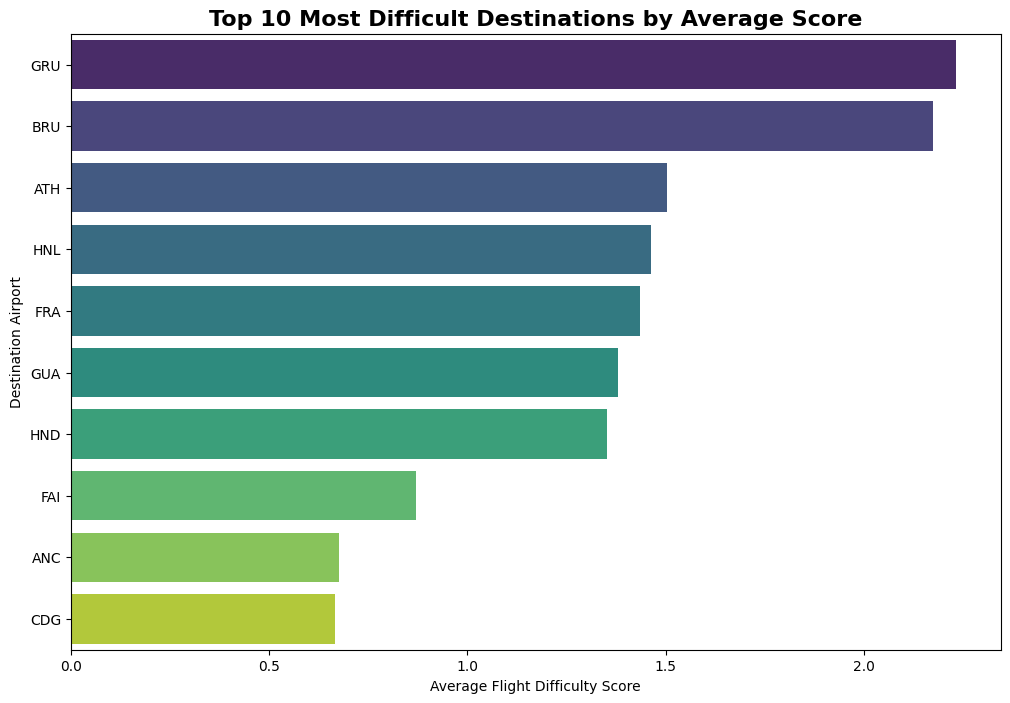

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# ====================================================================
#              VISUALIZATIONS FOR POST-ANALYSIS
# ====================================================================


# --- 1. Top 10 Destinations Bar Chart ---
# This chart visually ranks the top 10 destinations that have the highest
# average Flight Difficulty Score.
destination_summary = master_df.groupby('scheduled_arrival_station_code').agg(
    avg_difficulty_score=('difficulty_score', 'mean'),
    avg_departure_delay_minutes=('departure_delay_minutes', 'mean'),
    total_flights=('flight_key', 'count')
).sort_values(by='avg_difficulty_score', ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='avg_difficulty_score', y='scheduled_arrival_station_code', data=destination_summary, palette='viridis')
plt.title('Top 10 Most Difficult Destinations by Average Score', fontsize=16, weight='bold')
plt.xlabel('Average Flight Difficulty Score')
plt.ylabel('Destination Airport')
plt.show()




/tmp/ipython-input-4215540358.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation with Actual Delay', y='Feature', data=corr_df.sort_values('Correlation with Actual Delay', ascending=False), palette='coolwarm_r')


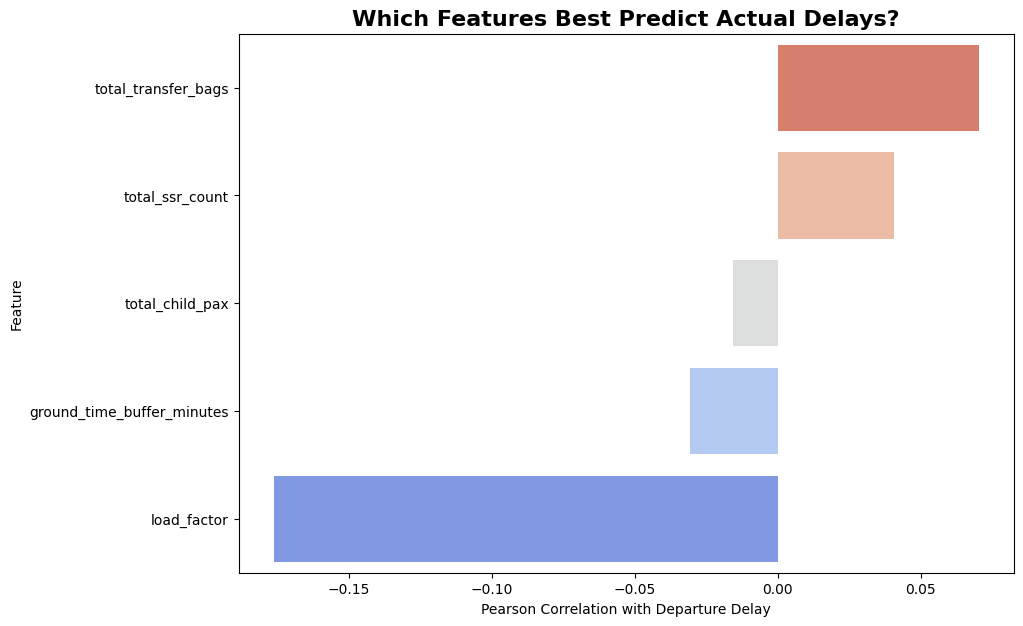

In [ ]:
# --- 2. Feature Correlation Bar Chart ---
# This chart shows the Pearson correlation between each of your engineered features
# and the actual departure delay.

corr_df_clean = master_df.dropna(subset=['departure_delay_minutes'] + feature_cols)
feature_delay_corr = corr_df_clean[['departure_delay_minutes'] + feature_cols].corr()['departure_delay_minutes'].sort_values(ascending=False).to_dict()

corr_data = []
for k, v in feature_delay_corr.items():
    if k != 'departure_delay_minutes':
        corr_data.append([k, v])

corr_df = pd.DataFrame(corr_data, columns=['Feature', 'Correlation with Actual Delay'])

plt.figure(figsize=(10, 7))
sns.barplot(x='Correlation with Actual Delay', y='Feature', data=corr_df.sort_values('Correlation with Actual Delay', ascending=False), palette='coolwarm_r')
plt.title('Which Features Best Predict Actual Delays?', fontsize=16, weight='bold')
plt.xlabel('Pearson Correlation with Departure Delay')
plt.ylabel('Feature')
plt.show()



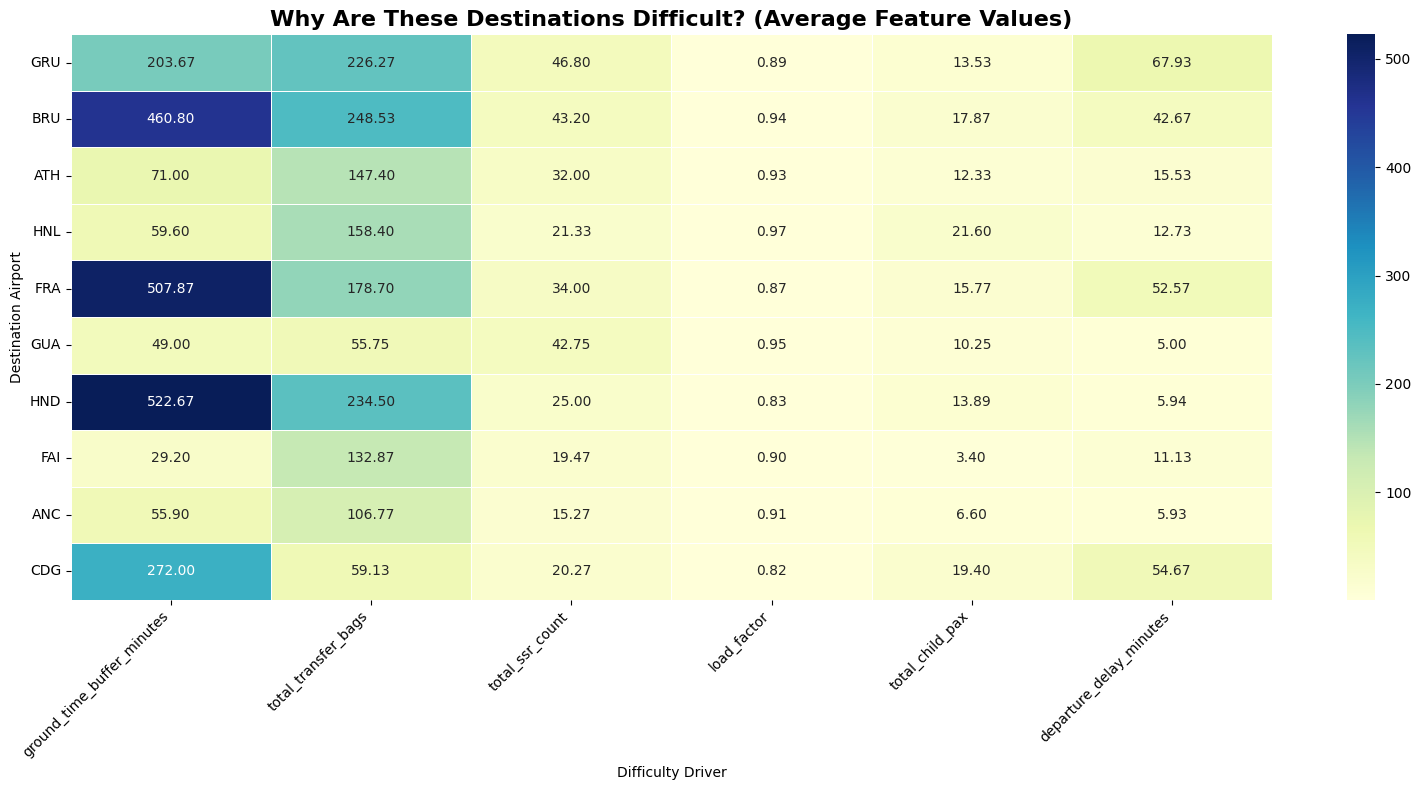

In [ ]:

# --- 3. Detailed Drivers Heatmap ---
# This heatmap provides a deep dive into why the top 10 destinations are difficult.
top_10_destinations = destination_summary['scheduled_arrival_station_code'].unique()
filtered_df = master_df[master_df['scheduled_arrival_station_code'].isin(top_10_destinations)]
driver_analysis = filtered_df.groupby('scheduled_arrival_station_code')[feature_cols + ['departure_delay_minutes']].mean()
# Reorder the rows to match the bar chart's order of difficulty
driver_analysis = driver_analysis.reindex(destination_summary['scheduled_arrival_station_code'])

plt.figure(figsize=(16, 8))
sns.heatmap(driver_analysis, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Why Are These Destinations Difficult? (Average Feature Values)', fontsize=16, weight='bold')
plt.xlabel('Difficulty Driver')
plt.ylabel('Destination Airport')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()